In [1]:
import numpy as np
import matplotlib.pyplot as plt
import openmc
from matplotlib.colors import LogNorm

pitch = 1.26

# Load tally results from OpenMC statepoint file
statepoint = openmc.StatePoint("statepoint.1000.h5")  # Adjust batch number as needed

# ================
# Extract Tallies
# ================

# -----------
# Mesh Tally
# -----------
# Extract the tally of interest
tally = statepoint.get_tally(name="flux_at_right_boundary")

# Get tally data
flux = tally.mean  # The flux values (mean)
flux_uncertainty = tally.std_dev  # The standard deviation
flux[np.where(flux <= flux_uncertainty)] = 0

# Extract filters for normalization
mesh_filter = tally.find_filter(openmc.MeshFilter)
energy_filter = tally.find_filter(openmc.EnergyFilter)
angle_filter = tally.find_filter(openmc.AzimuthalFilter)

E_min = energy_filter.bins[0][0]
E_max = energy_filter.bins[-1][-1]

Ny = len(mesh_filter.bins)
NE = len(energy_filter.bins)
Nω = len(angle_filter.bins)

flux = flux[:, 0, 0].reshape([Ny, Nω, NE], order='C')

# Get bin widths for normalization
delta_y = pitch/Ny
delta_omega = angle_filter.bins[0][1] - angle_filter.bins[0][0]
delta_E = np.diff(energy_filter.bins)[:, 0]  # Energy group widths

# Normalize the flux
flux_normalized = flux / (delta_y * delta_omega * delta_E[np.newaxis, np.newaxis, :])

# Select a representative slice for each variable
# Example: fixing energy group, angle, or y-axis index
energy_index = len(delta_E) // 4  # Representative energy group (middle of the spectrum)
angle_index = len(angle_filter.bins) // 2  # Representative angle (middle bin)
mesh_index = Ny // 2  # Representative y-axis index (middle of the mesh)

Process flux distribution into moments and compute functional expansion

In [2]:
from scipy.special import legendre
from scipy.integrate import simpson

I = 10 # Spatial order +1
J = 4 # Angular order +1

coefs = np.zeros((I, J, NE, 2))

bins = np.linspace(-pitch / 2, pitch / 2, Ny + 1)
y_vals = (bins[:-1] + bins[1:]) / 2  # Correctly compute the centers of the bins
ω_vals = (angle_filter.values[:-1] + angle_filter.values[1:]) / 2
E_vals = (energy_filter.values[:-1] + energy_filter.values[1:]) / 2

Y, Ω = np.meshgrid(y_vals, ω_vals)

# Basis functions in integrand
def integrand_functions(i, j, vector_index):
    if vector_index == 0:
        def integrand(y, ω):
            return np.cos(i*np.pi* y/(pitch/2))*legendre(j)(np.sin(ω))*np.cos(ω)
    elif vector_index == 1:
        def integrand(y, ω):
            return np.sin(i*np.pi* y/(pitch/2))*legendre(j)(np.sin(ω))*np.cos(ω)
    else:
        raise ValueError(f"vector_index must be 0 or 1, you supplied {vector_index}")
    return integrand

def evaluate_integrand(integrand_function, y_vals, ω_vals):
    integrand_eval = np.zeros((len(y_vals), len(ω_vals)))
    for y_idx, y in enumerate(y_vals):
        for ω_idx, ω in enumerate(ω_vals):
            integrand_eval[y_idx, ω_idx] = integrand_function(y, ω)
    return integrand_eval

for i in range(I):
    for j in range(J):
        # Now compute the relevant coefficients by computing quadrature approximations of the integrals
        for vector_index in range(2):
            # Evaluate integrand functions on spatial and angular mesh
            integrand_function = integrand_functions(i, j, vector_index)
            integrand_eval = evaluate_integrand(integrand_function, y_vals, ω_vals)
            
            for k in range(NE):
                # Now multiply the basis functions with the flux
                integrand_eval = integrand_eval * flux_normalized[:, :, k]
                if i==0: # Integral over cosine with zero angular frequency causes different prefactor
                    if vector_index == 0:
                        coefs[i, j, k, vector_index] = (2*j+1)/(2*pitch)*simpson(simpson(integrand_eval, y_vals, axis=0), ω_vals, axis=0)
                    else: # Sine basis integral is zero
                        coefs[i, j, k, vector_index] = 0
                else:
                    coefs[i, j, k, vector_index] = (2*j+1)/(pitch)*simpson(simpson(integrand_eval, y_vals, axis=0), ω_vals, axis=0)

Now we have the relevant coefficients to reconstruct the flux as a continuous function of all variables except E

In [3]:
def basis_function(i, j, vector_index):
    if vector_index == 0:
        def basis(y, ω):
            return np.cos(i*np.pi* y/(pitch/2))*legendre(j)(np.sin(ω))
    elif vector_index == 1:
        def basis(y, ω):
            return np.sin(i*np.pi* y/(pitch/2))*legendre(j)(np.sin(ω))
    else:
        raise ValueError(f"vector_index must be 0 or 1, you supplied {vector_index}")
    return basis

def reconstructed_flux(y, ω, E):
    E_idx = 0
    for bin_idx, bin in enumerate(energy_filter.bins):
        if bin[0] <= E <= bin[1]:
            E_idx = bin_idx

    flux = 0
    for i in range(I):
        for j in range(J):
            for vector_index in range(2):
                flux += coefs[i, j, E_idx, vector_index]*basis_function(i, j, vector_index)(y, ω)

    return flux

First compare the reconstructed flux with the mesh tally

In [4]:
reconstructed_flux_vals = np.zeros((Ny, Nω, NE))
for i, y in enumerate(y_vals):
    for j, ω in enumerate(ω_vals):
        for k, E in enumerate(E_vals):
            reconstructed_flux_vals[i, j, k] = np.abs(reconstructed_flux(y, ω, E)) # Absolute value included to exclude artifactual negative values that mess up plots

In [5]:
def plot_flux(flux, energy_index, angle_index, mesh_index):
    # Plot a 2D slice with energy fixed
    flux_energy_slice = flux[:, :, energy_index]  # Fix energy
    print(flux_energy_slice.shape)
    plt.figure(figsize=(8, 6))
    plt.imshow(flux_energy_slice.T, origin="lower", extent=[-pitch/2, pitch/2, -np.pi/2, np.pi/2], aspect="auto",norm=LogNorm())
    plt.colorbar(label="Flux (normalized)")
    plt.xlabel("y-position")
    plt.ylabel("Angle (rad)")
    plt.title(f"Flux Slice at Energy {(energy_filter.bins[energy_index][1] - energy_filter.bins[energy_index][0])/2} eV")
    plt.show()

    # Plot a 2D slice with angle fixed
    flux_angle_slice = flux[:, angle_index, :]  # Fix angle
    plt.figure(figsize=(8, 6))
    plt.imshow(flux_angle_slice.T, origin="lower", extent=[-pitch/2, pitch/2, E_min, E_max], aspect="auto",norm=LogNorm())
    plt.colorbar(label="Flux (normalized)")
    plt.ylabel("Energy (eV)")
    plt.xlabel("y-position")
    plt.title(f"Flux Slice at Angle {(angle_filter.bins[angle_index][1] - angle_filter.bins[angle_index][0])/2} radians")
    plt.show()

    # Plot a 2D slice with y fixed
    flux_y_slice = flux[mesh_index, :, :]  # Fix y location
    plt.figure(figsize=(8, 6))
    plt.imshow(flux_y_slice.T, origin="lower", extent=[-np.pi/2, np.pi/2, E_min, E_max], aspect="auto",norm=LogNorm())
    plt.colorbar(label="Flux (normalized)")
    plt.ylabel("Energy (eV)")
    plt.xlabel("Angle (rad)")
    plt.title(f"Flux Slice at y-position Index {mesh_index}")
    plt.show()

(50, 20)


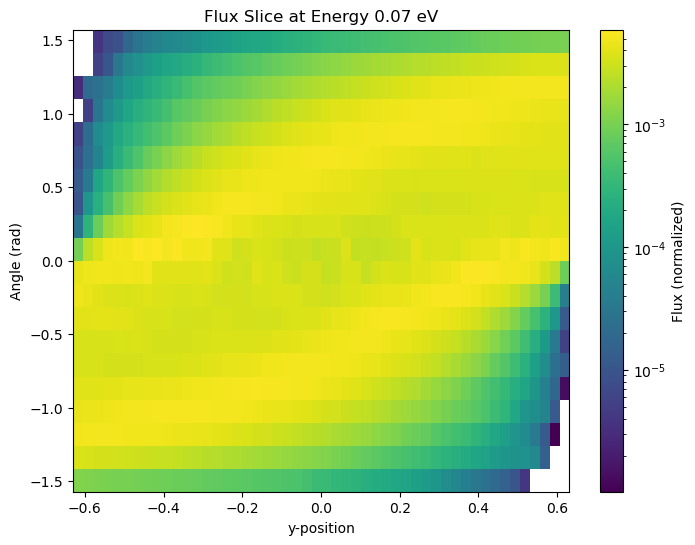

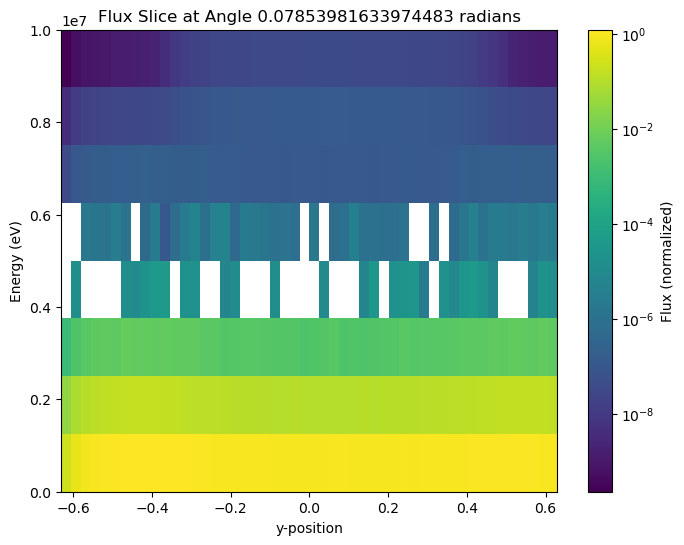

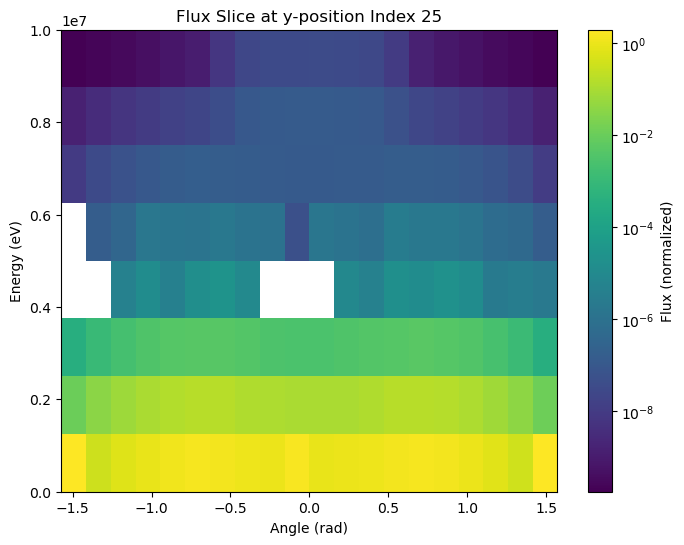

In [15]:
plot_flux(flux_normalized, energy_index, angle_index, mesh_index)

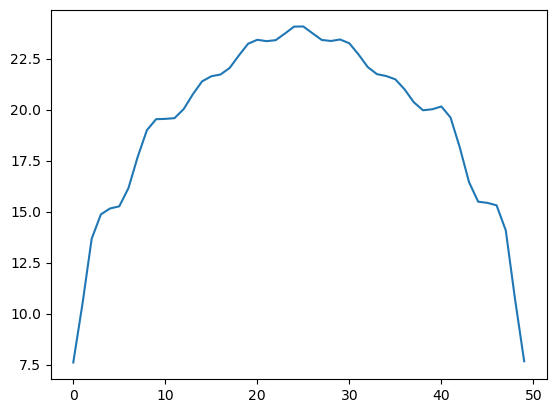

In [7]:
plt.plot(np.sum(reconstructed_flux_vals, (1,2)))

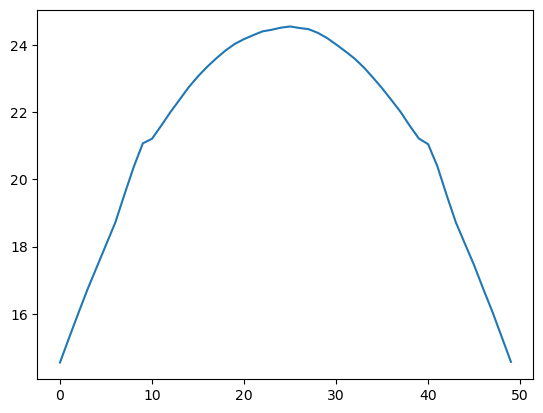

In [8]:
plt.plot(np.sum(flux_normalized, (1,2)))

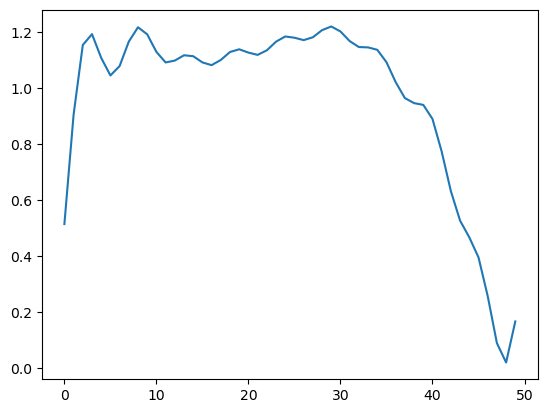

In [9]:
plt.plot(reconstructed_flux_vals[:, 6,0])

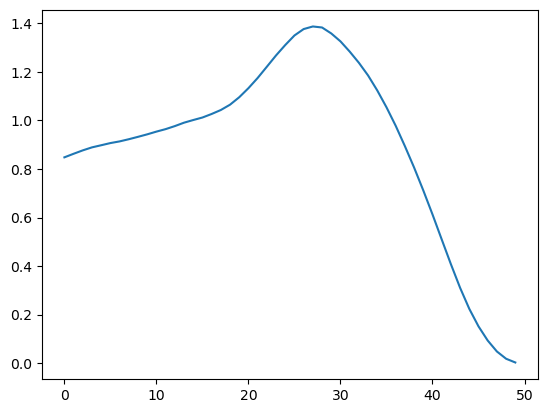

In [10]:
plt.plot(flux_normalized[:, 6,0])